# Druglikeness

In the previous notebook, we played with the concept of molecular descriptors, and compared our sets of known ligands to known therapeutic drugs contained in the DrugBank database, using several common descriptors. This already gave you some information on how do your selected ligands compare to known drugs.

While we can compare the two sets any which way, there are also some widely established rules of thumb for identifying [drug-like](https://en.wikipedia.org/wiki/Druglikeness) structures, i.e. small molecules that have a chance to be reasonably potent, selective, and, above all, able to reach the therapeutic target (receptor) when [ingested](https://en.wikipedia.org/wiki/Bioavailability). Nobody wants to inject their medication into theirs veins, unless absolutely necessary. More on biological availability [here](http://howmed.net/pharmacology/bioavailability-of-drugs/).

The most known set of rules for biological availability is the Lipinski's [rule of five](https://en.wikipedia.org/wiki/Lipinski%27s_Rule_of_Five) (LRO5). It states that molecules can be expected to have good bioavailability when:
 - no more than 5 hydrogen bond donors
 - no more than 10 hydrogen bond acceptors
 - molecular weight of less than 500 Da
 - logP less than 5

The above are just general rules of thumb, to avoid excesively large, greasy molecules that would have serious problems getting to the target in a real organism. In most applications, molecules that violate only one of the aforedescribed rules still get a passing mark. A more complex insight on LRO5 can be read [here](https://blogs.sciencemag.org/pipeline/archives/2005/02/14/bigger_and_greasier). I would recommend reading dr. Lowe's stuff in general to get some idea about drug discover/development from pharma chemist's perspective. Since there is no sense of me reiterating anymore of what is already readily available on your materials from lectures and also from Wikipedia, let's try and implement this filter on our own:

In [1]:
# just the usual housekeeping, import libraries, load ligand and DrugBank data
# you load your own set, and DrugBank :)
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors as rdescriptors
from rdkit.Chem.Draw import IPythonConsole
import csv

with open('../data/chembl_mtor_ic50.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=";")
    mtor_ligands = [Chem.MolFromSmiles(m['Smiles']) for m in reader]

suppl = Chem.SDMolSupplier('../data/drugbank.sdf')
drugs = [m for m in suppl if m]

[10:46:06] Explicit valence for atom # 7 N, 4, is greater than permitted
[10:46:06] ERROR: Could not sanitize molecule ending on line 20009
[10:46:06] ERROR: Explicit valence for atom # 7 N, 4, is greater than permitted
[10:46:06] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
[10:46:06] ERROR: Could not sanitize molecule ending on line 250947
[10:46:06] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
[10:46:06] Explicit valence for atom # 17 O, 3, is greater than permitted
[10:46:06] ERROR: Could not sanitize molecule ending on line 258130
[10:46:06] ERROR: Explicit valence for atom # 17 O, 3, is greater than permitted
[10:46:06] Can't kekulize mol.  Unkekulized atoms: 57 58 59 60 61 62 63 64 65
[10:46:06] ERROR: Could not sanitize molecule ending on line 261581
[10:46:06] ERROR: Can't kekulize mol.  Unkekulized atoms: 57 58 59 60 61 62 63 64 65
[10:46:06] Can't kekulize mol.  Unkekulized atoms: 0 1 2 6 7 8 9 10 11 12 13 14 15 16 17
[10:46:06] ERROR: Coul

[10:46:06] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 8 9 10
[10:46:06] ERROR: Could not sanitize molecule ending on line 659994
[10:46:06] ERROR: Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 8 9 10
[10:46:06] Explicit valence for atom # 0 Be, 3, is greater than permitted
[10:46:06] ERROR: Could not sanitize molecule ending on line 995692
[10:46:06] ERROR: Explicit valence for atom # 0 Be, 3, is greater than permitted
[10:46:07] Explicit valence for atom # 0 C greater than permitted
[10:46:07] ERROR: Could not sanitize molecule ending on line 1151592
[10:46:07] ERROR: Explicit valence for atom # 0 C greater than permitted


There are many ways to implement a Lipinski filter, since it is just a value cutoff. But, we might as well get fancy and implement it using functions. You can do whichever way you prefer :)

In [2]:
def too_many_hbd(mol):
    # takes an RDKit mol instance, returns True if the structure is out of LRO5 bounds
    return rdescriptors.CalcNumLipinskiHBD(mol) > 5

def too_many_hba(mol):
    return rdescriptors.CalcNumLipinskiHBA(mol) > 10

def too_heavy(mol):
    return rdescriptors.CalcExactMolWt(mol) > 500

def too_greasy(mol):
    return Descriptors.MolLogP(mol) > 5

Let's take a peek at some random structure from our set, and try to apply our filters:

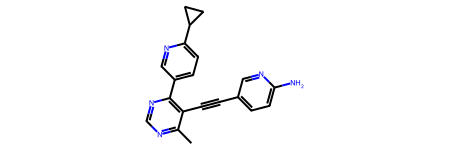

In [3]:
mtor_ligands[666]

In [4]:
# and see how the structure fares
too_many_hbd(mtor_ligands[666]), too_many_hba(mtor_ligands[666]), \
too_heavy(mtor_ligands[666]), too_greasy(mtor_ligands[666])

(False, False, False, False)

So, no Lipinski red flags for our 666 ligand. It seems biologically available. What about your randomly picked ligand?

Let's evaluate the whole ligand set :)

In [5]:
mtor_ligands_too_many_hbd = [too_many_hbd(l) for l in mtor_ligands]
mtor_ligands_too_many_hba = [too_many_hba(l) for l in mtor_ligands]
mtor_ligands_too_heavy = [too_heavy(l) for l in mtor_ligands]
mtor_ligands_too_greasy = [too_greasy(l) for l in mtor_ligands]
sum(mtor_ligands_too_many_hbd), sum(mtor_ligands_too_many_hba), \
sum(mtor_ligands_too_heavy), sum(mtor_ligands_too_greasy), len(mtor_ligands)

(7, 850, 1357, 223, 4596)

So, from this crude view on data, it looks like most of the 4596 molecules within this mtor set pass the RO5. The biggest problem seems to be that over a quarter of the molecules seem too heavy, and there are also quite a few with too many hydrogen bond acceptors (N, O, other heteroatoms), which should come as no surprise given the results in the previous exercise. On the other hand, greasiness and the amount of hydrogen bond donors do not seem to be much of a factor here. Let's make the data look a bit nicer:

In [6]:
import pandas as pd
df = pd.DataFrame(data={'set':'mtor',
                        'too_many_hbd': mtor_ligands_too_many_hbd,
                        'too_many_hba': mtor_ligands_too_many_hba,
                        'too_greasy': mtor_ligands_too_greasy,
                        'too_heavy': mtor_ligands_too_heavy})
df

,set,too_many_hbd,too_many_hba,too_greasy,too_heavy
0,mtor,False,False,False,False
1,mtor,False,False,False,False
2,mtor,False,False,False,False
3,mtor,False,False,False,False
4,mtor,False,False,False,False
...,...,...,...,...,...
4591,mtor,False,False,False,False
4592,mtor,False,False,False,False
4593,mtor,False,False,False,False
4594,mtor,False,False,False,False


/tmp/ipykernel_207941/3158178820.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  p = sns.barplot(data=df, ci=None)


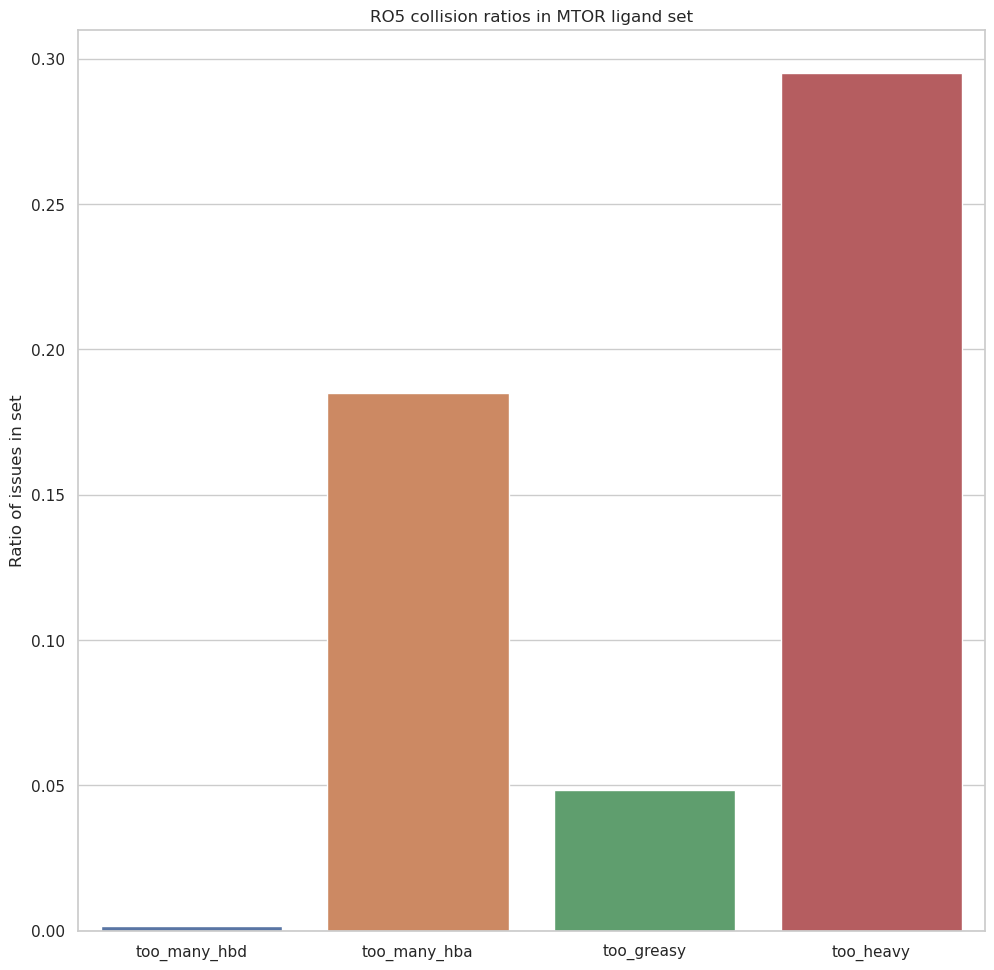

In [7]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7, 11.7)}) # for bigger graphs
with sns.axes_style("whitegrid"):
    p = sns.barplot(data=df, ci=None)
    p.set_title("RO5 collision ratios in MTOR ligand set")
    p.set_ylabel("Ratio of issues in set")

Same data with a bit more flair, showing Lipinski RO5 issues with the mtor ligand set. You do your ligand set :)

So, here the biggest issue is that structures are too heavy. However, the common interpretation of LRO5 permits a single violation. Therefore, many of the too heavy structures may still pass the Lipinski filter. Let's implement it in full:

In [8]:
def ro5_violations(mol):
    # takes RDKit mol, return how many rules it actually violates
    return sum([too_many_hbd(mol), too_many_hba(mol), too_heavy(mol), too_greasy(mol)])

def violates_lipinski(mol):
    # checks the number of RO5 violations, if they are more than one, return True
    return ro5_violations(mol) > 1

In [9]:
# let's apply those functions on our mtor set:
mtor_ro5_violations = [ro5_violations(l) for l in mtor_ligands]
mtor_violates_lipinski = [violates_lipinski(l) for l in mtor_ligands]
sum(mtor_ro5_violations),\
sum(mtor_ro5_violations)/len(mtor_ro5_violations),\
sum(mtor_violates_lipinski),\
sum(mtor_violates_lipinski)/len(mtor_violates_lipinski)

(2437, 0.5302436901653612, 768, 0.1671018276762402)

So, the overall amount of RO5 violations in the MTOR set seems to be 2437, which is about half RO5 violations per molecule. 768 MTOR ligands, which is about 17%, violate more than one LRO5 rule, and thus fail the standard Lipinski filter. What are the stats for your set?

let's add the lipinski pass data into the dataframe and visualize again:

/tmp/ipykernel_207941/1733184408.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  p = sns.barplot(data=df, ci=None)


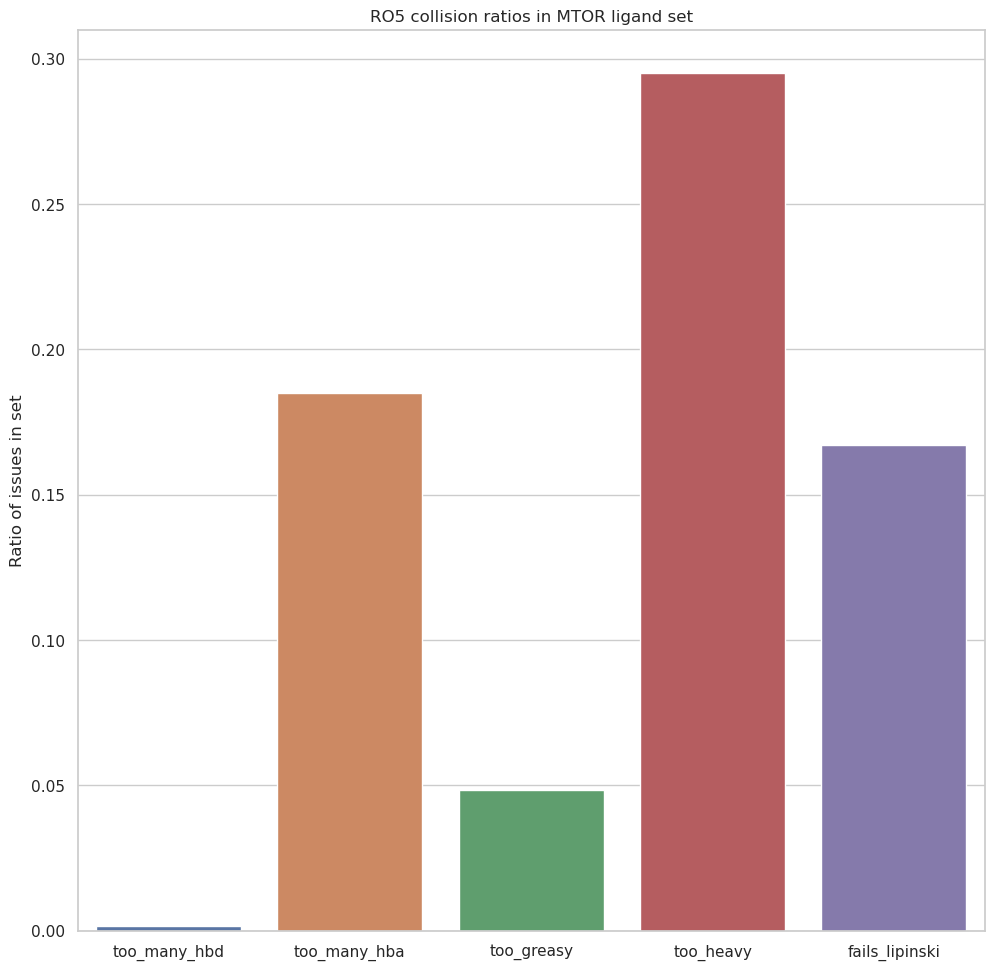

In [10]:
df['fails_lipinski'] = mtor_violates_lipinski
with sns.axes_style("whitegrid"):
    p = sns.barplot(data=df, ci=None)
    p.set_title("RO5 collision ratios in MTOR ligand set")
    p.set_ylabel("Ratio of issues in set")

Cool. Still, [Lipinski](https://en.wikipedia.org/wiki/Lipinski%27s_rule_of_five) is not the only filter in town. To get a more comprehensive picture, let's implement some more, to get a more comprehensive picture. Let's do the Ghose extension that remaps the requirements for logP and molecular weight, and instead of HBA and HBD uses molar refractivity and number of atoms. Also the Veber's rule on rotatable bonds and polar surface area:

In [11]:
from rdkit.Chem import Crippen

def bad_greasyness_ghose(mol):
    logp = Descriptors.MolLogP(mol)
    return logp > 5.6 or logp < -0.4

# let's apply the filters and add them to the dataframe as we go
df['odd_greasyness'] = [bad_greasyness_ghose(l) for l in mtor_ligands]

def bad_refractivity_ghose(mol):
    ref = Crippen.MolMR(mol)
    return ref > 130 or ref < 40
df['odd_refractivity'] = [bad_refractivity_ghose(l) for l in mtor_ligands]

def bad_mw_ghose(mol):
    mw = rdescriptors.CalcExactMolWt(mol)
    return mw > 480 or mw < 180
df['odd_mass'] = [bad_mw_ghose(l) for l in mtor_ligands]

def bad_atomcount_ghose(mol):
    ac = mol.GetNumHeavyAtoms()
    return ac > 70 or ac < 20
df['odd_atomcount'] = [bad_atomcount_ghose(l) for l in mtor_ligands]

def violates_ghose(mol):
    return bad_greasyness_ghose(mol) or bad_refractivity_ghose(mol) or bad_mw_ghose(mol) or bad_atomcount_ghose(mol)
df['fails_ghose'] = [violates_ghose(l) for l in mtor_ligands]

def too_rotatable_veber(mol):
    return Chem.CalcNumRotatableBonds(mol) > 10
df['too_rotatable'] = [too_rotatable_veber(l) for l in mtor_ligands]

def too_large_psa_veber(mol):
    return rdescriptors.CalcTPSA(mol) > 140
df['excessive_psa'] = [too_large_psa_veber(l) for l in mtor_ligands]

def violates_veber(mol):
    return too_rotatable_veber(mol) or too_large_psa_veber(mol)
df['fails_veber'] = [violates_veber(l) for l in mtor_ligands]

... And visualize our masterpiece :)

/tmp/ipykernel_207941/1319469689.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  p = sns.barplot(data=df, ci=None)


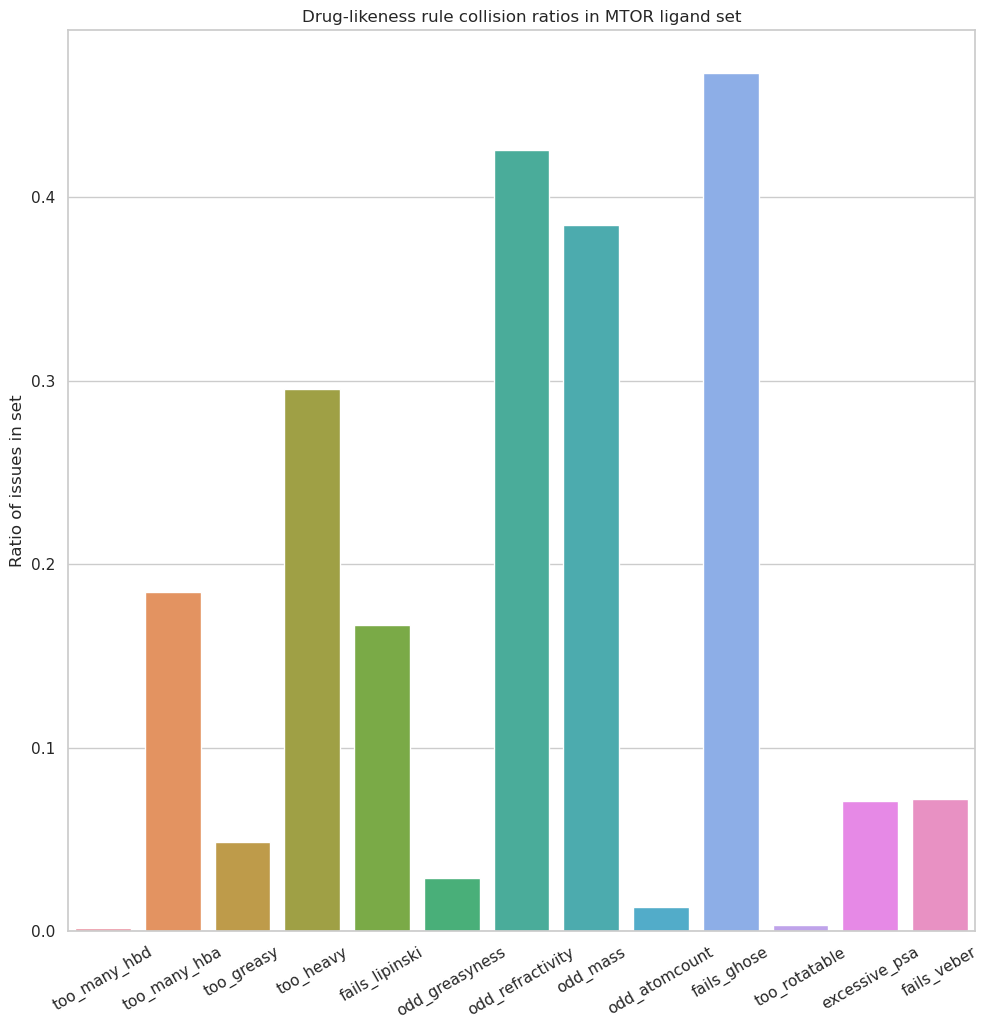

In [12]:
with sns.axes_style("whitegrid"):
    p = sns.barplot(data=df, ci=None)
    p.set_title("Drug-likeness rule collision ratios in MTOR ligand set")
    p.set_ylabel("Ratio of issues in set")
    p.set_xticklabels(p.get_xticklabels(), rotation=30) # avoid ugly text clipping

All right, this should be enough :) So, almost half of the MTOR ligands fail Ghose filter, on bad molar refractivity (i.e. [polarizability](https://en.wikipedia.org/wiki/Polarizability)) and no doubt some on the large size of the molecules, as already shown on the Lipinski RO5 failures. Also, there have to be same light enough to be also clipped by the lower bound of the Ghose molecular mass requirements. As for Veber rules, these apper to be only a little factor, almost no MTOR ligands from the analyzed set have too many rotatable bonds, and only few have too much [polar surface area](https://en.wikipedia.org/wiki/Polar_surface_area), which could give them trouble when getting through cell membranes.

The MTOR set appear quite viable from drug-likeness perspective. What about yours?

Also, it would be good to put the values in some perspective. Even DrugBank contains some amount of structures that are outside of drug-likeness bounds, some simply because the rules are quite crude tools, others may be substances than can rely on active transport within the organism, and other like [insulin](https://www.drugbank.ca/categories/DBCAT000170) are simply not meant for peroral use. Let's get the stats for DrugBank:


In [13]:
df_drugbank = pd.DataFrame(
    data={'set':'DrugBank',
          'too_many_hbd': [too_many_hbd(l) for l in drugs],
          'too_many_hba': [too_many_hba(l) for l in drugs],
          'too_greasy': [too_greasy(l) for l in drugs],
          'too_heavy': [too_heavy(l) for l in drugs],
          'fails_lipinski': [violates_lipinski(l) for l in drugs],
          'odd_greasyness': [bad_greasyness_ghose(l) for l in drugs],
          'odd_refractivity': [bad_refractivity_ghose(l) for l in drugs],
          'odd_mass': [bad_mw_ghose(l) for l in drugs],
          'odd_atomcount': [bad_atomcount_ghose(l) for l in drugs],
          'fails_ghose': [violates_ghose(l) for l in drugs],
          'too_rotatable': [too_rotatable_veber(l) for l in drugs],
          'excessive_psa': [too_large_psa_veber(l) for l in drugs],
          'fails_veber': [violates_veber(l) for l in drugs]})
df_drugbank

,set,too_many_hbd,too_many_hba,too_greasy,too_heavy,fails_lipinski,odd_greasyness,odd_refractivity,odd_mass,odd_atomcount,fails_ghose,too_rotatable,excessive_psa,fails_veber
0,DrugBank,True,True,False,True,True,True,True,True,True,True,True,True,True
1,DrugBank,True,True,False,True,True,True,True,True,True,True,True,True,True
2,DrugBank,True,True,False,True,True,True,True,True,True,True,True,True,True
3,DrugBank,True,True,False,True,True,True,True,True,True,True,True,True,True
4,DrugBank,False,True,False,True,True,False,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7112,DrugBank,False,False,False,False,False,False,True,True,True,True,False,False,False
7113,DrugBank,False,False,False,False,False,True,False,False,False,True,False,True,True
7114,DrugBank,True,True,False,True,True,False,True,True,True,True,True,True,True
7115,DrugBank,False,False,False,False,False,False,False,False,False,False,True,False,True


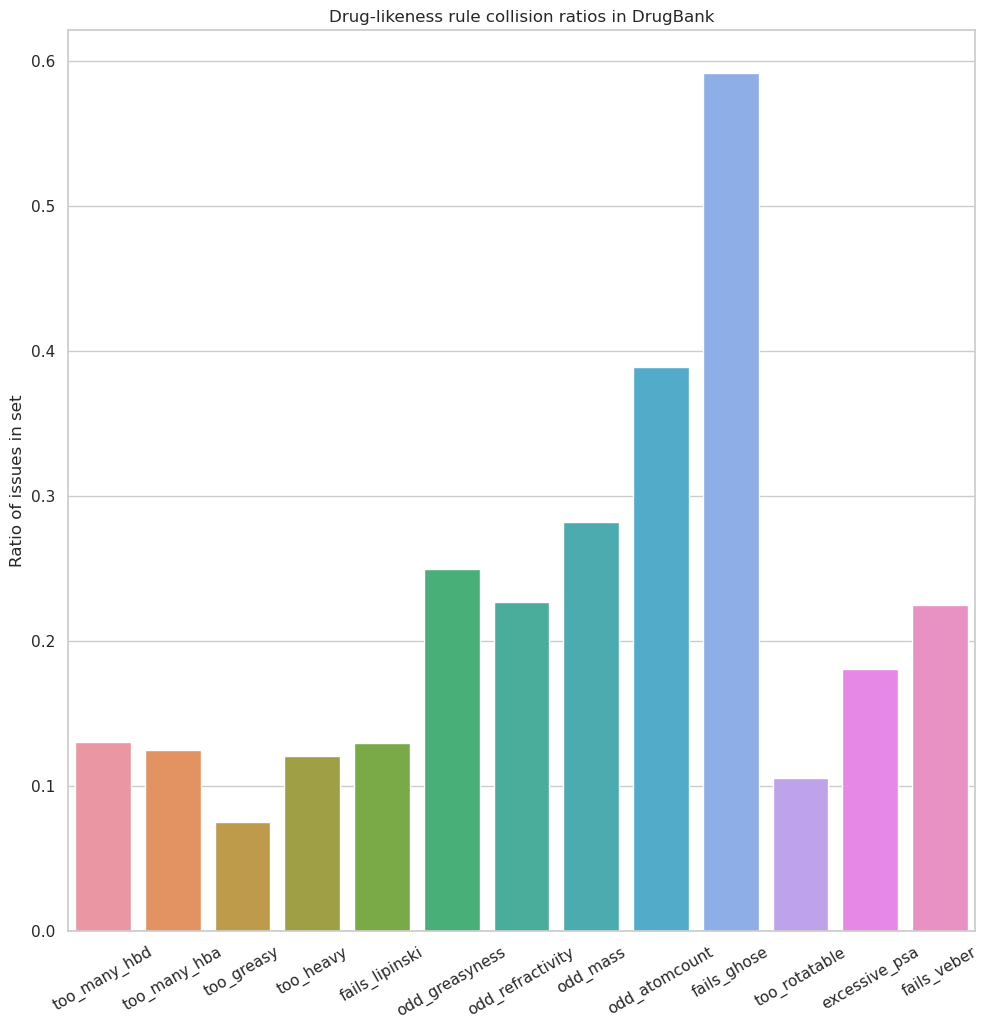

In [14]:
# let's visualize this monstrosity:
with sns.axes_style("whitegrid"):
    p = sns.barplot(data=df_drugbank, errorbar=None)
    p.set_title("Drug-likeness rule collision ratios in DrugBank")
    p.set_ylabel("Ratio of issues in set")
    p.set_xticklabels(p.get_xticklabels(), rotation=30) # avoid ugly text clipping

Apparently, known drugs from DrugBank aren't perfect either. It has less failures in the Lipinski filter, but Ghose and Veber filters stats are even worse than with the MTOR ligand set. Where MTOR has more problems with molecular refractivity and mass, DrugBank content seems to have relatively more issues with greasiness, raw atom count, rotatable bonds and polar surface area.

This demonstrates that the Lipinski and indeed all other similar filters should be used as they are intended: as rough outlines of druglike properties, not as an evangelium. They can help you identify the truly hopeless structures, but there is no need to thrash an otherwise promising molecule just because it violates one or two rules.

# What to do
 - Have a look at Lipinski and other filters, linked in the workflow
 - Implement the rules, either as done here, or by other methods of your preference. Please try not to just copypaste the solution, and make sure that you understand what is being done. I can't freeze frame the classroom projector here, so honor system only :)
 - Run the filters on your set, evaluate the results, compare with MTOR results, and with DrugBank
 - How many ligands in your set fail the filters, what is their ratio?
 - What rules are the most frequently failed ones? 
 - How does the absolute numbers, as well as failure rate of individual rules compare to MTOR ligands and DrugBank?
 - Finally, to not just copypaste code, also look at lead-likeness filter, which is even more stringent than drug-likeness one (LogP 3 or less, molecular weight below 300 Da, max 3 HBA, max 3 HBD, and no more than 3 rotatable bonds). It is more strict so that there is some extra space for pharmaceutical lead to be further developed for specificity and/or potency by adding additional groups without the molecule getting too large and greasy. Implement this filter much like the Lipinski or Ghose one, and perform the corresponding visualizations. How many of your known ligands have lead-like properties that would make them good candidates for further drug development? How do the already developed drugs in DrugBank fare against your filter?